# Step-1: Setup, Configuration, and Data Loading

In this step, we:
- Import all the required Python libraries (NumPy, Pandas, Matplotlib, Seaborn, etc.).
- Load the training and test datasets.
- Display basic dataset information: shape, column names, missing values, and data types.
- Perform a quick sanity check to ensure the data is properly loaded.
- Generate a few sample rows to visually inspect data quality and patterns.

**Goal:** Understand the dataset structure and identify potential issues early.


In [1]:
# ===============================================================
# STEP 1 — Setup, Configuration, and Data Loading
# ===============================================================

# Standard libraries
import os
import gc
import sys
from datetime import datetime

# Data & ML libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# ===============================================================
# CONFIGURATION
# ===============================================================
CONFIG = {
    "seed": 42,
    "n_folds": 5,
    "target": "accident_risk",
    "id_col": "id",
    "train_path": "/kaggle/input/playground-series-s5e10/train.csv",
    "test_path":  "/kaggle/input/playground-series-s5e10/test.csv",
    "sub_path":   "/kaggle/input/playground-series-s5e10/sample_submission.csv",
    "use_stratified": False,  # toggle if target is categorical
}

# ===============================================================
# UTILITY FUNCTIONS
# ===============================================================
def log(msg: str):
    """Print timestamped log messages for cleaner outputs."""
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

def set_seed(seed: int = 42):
    """Ensure reproducibility across NumPy, Python, and LightGBM."""
    np.random.seed(seed)
    log(f"Random seed set to {seed}")

def load_data(train_path: str, test_path: str, sub_path: str):
    """Load train, test, and submission CSV files."""
    log("Loading datasets ...")
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    sub = pd.read_csv(sub_path)

    log(f"✅ Train shape: {train.shape}")
    log(f"✅ Test shape : {test.shape}")
    log(f"✅ Columns: {list(train.columns[:10])} ...")

    return train, test, sub

def show_versions():
    """Display key library versions for reproducibility."""
    log("Library versions:")
    print(f"Python: {sys.version.split()[0]}")
    print(f"NumPy: {np.__version__}")
    print(f"Pandas: {pd.__version__}")
    print(f"LightGBM: {lgb.__version__}")

# ===============================================================
# MAIN EXECUTION
# ===============================================================
set_seed(CONFIG["seed"])
show_versions()

# Load data
train, test, sub = load_data(
    CONFIG["train_path"],
    CONFIG["test_path"],
    CONFIG["sub_path"]
)

# Basic cleanup to free memory early
gc.collect()

[18:08:48] Random seed set to 42
[18:08:48] Library versions:
Python: 3.11.13
NumPy: 1.26.4
Pandas: 2.2.3
LightGBM: 4.6.0
[18:08:48] Loading datasets ...
[18:08:49] ✅ Train shape: (517754, 14)
[18:08:49] ✅ Test shape : (172585, 13)
[18:08:49] ✅ Columns: ['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day'] ...


0

# Step 2: Exploratory Data Analysis (EDA)

Here we perform a detailed exploration of the dataset to uncover:
- Statistical summaries (mean, median, skewness, etc.)
- Correlation between features
- Outliers and missing value patterns
- Distribution of key numeric features
- Relationships between target variable and top correlated features
- A correlation heatmap for a visual overview of feature relationships

**Goal:** Gain insights into feature behavior, detect noise or bias, and plan preprocessing/feature engineering steps.


[18:08:50] Starting EDA ...
[18:08:50] Basic dataset info:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,517754.0,NaN,NaN,NaN,258876.5,149462.849974,0.0,129438.25,258876.5,388314.75,517753.0
road_type,517754,3,highway,173672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lanes,517754.0,NaN,NaN,NaN,2.491511,1.120434,1.0,1.0,2.0,3.0,4.0
curvature,517754.0,NaN,NaN,NaN,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,NaN,NaN,NaN,46.112575,15.788521,25.0,35.0,45.0,60.0,70.0
lighting,517754,3,dim,183826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,517754,3,foggy,181463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_signs_present,517754,2,False,259289,NaN,NaN,NaN,NaN,NaN,NaN,NaN
public_road,517754,2,True,260045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_of_day,517754,3,morning,173410,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[18:08:50] Checking missing values ...


Series([], dtype: float64)

[18:08:51] Target variable distribution:


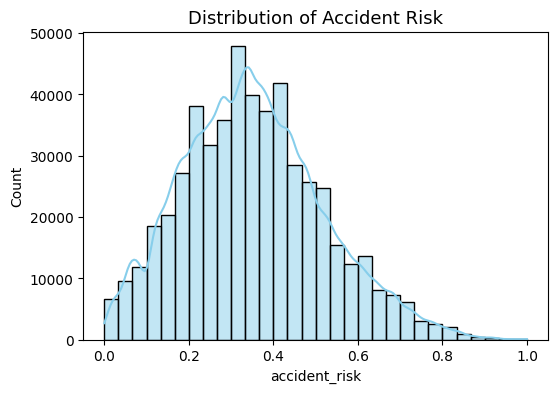

Target mean: 0.3524
Target median: 0.3400
Target std: 0.1664
[18:08:53] Detected 11 categorical and 1 numerical features.
[18:08:53] Example categorical features: ['road_type', 'num_lanes', 'speed_limit', 'lighting', 'weather']
[18:08:53] Example numerical features: ['curvature']


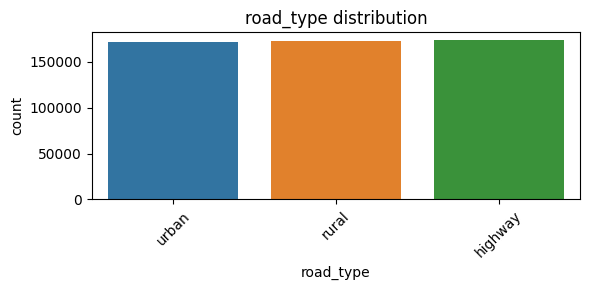

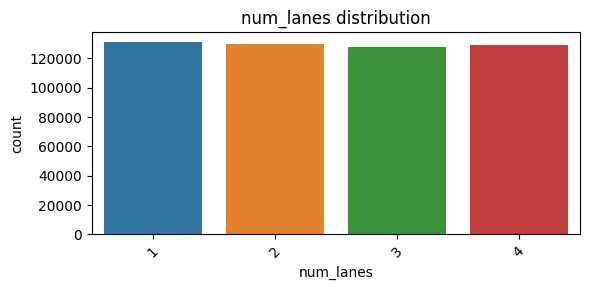

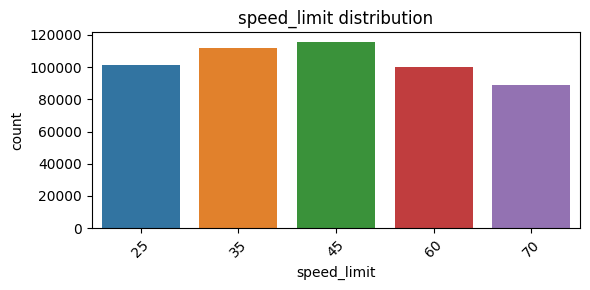

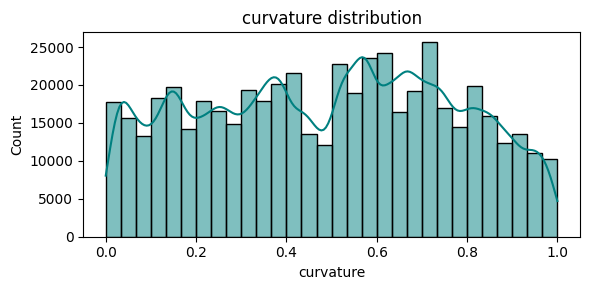

[18:08:57] ⚙️ Created fallback 'encoded' DataFrame for correlation heatmap.


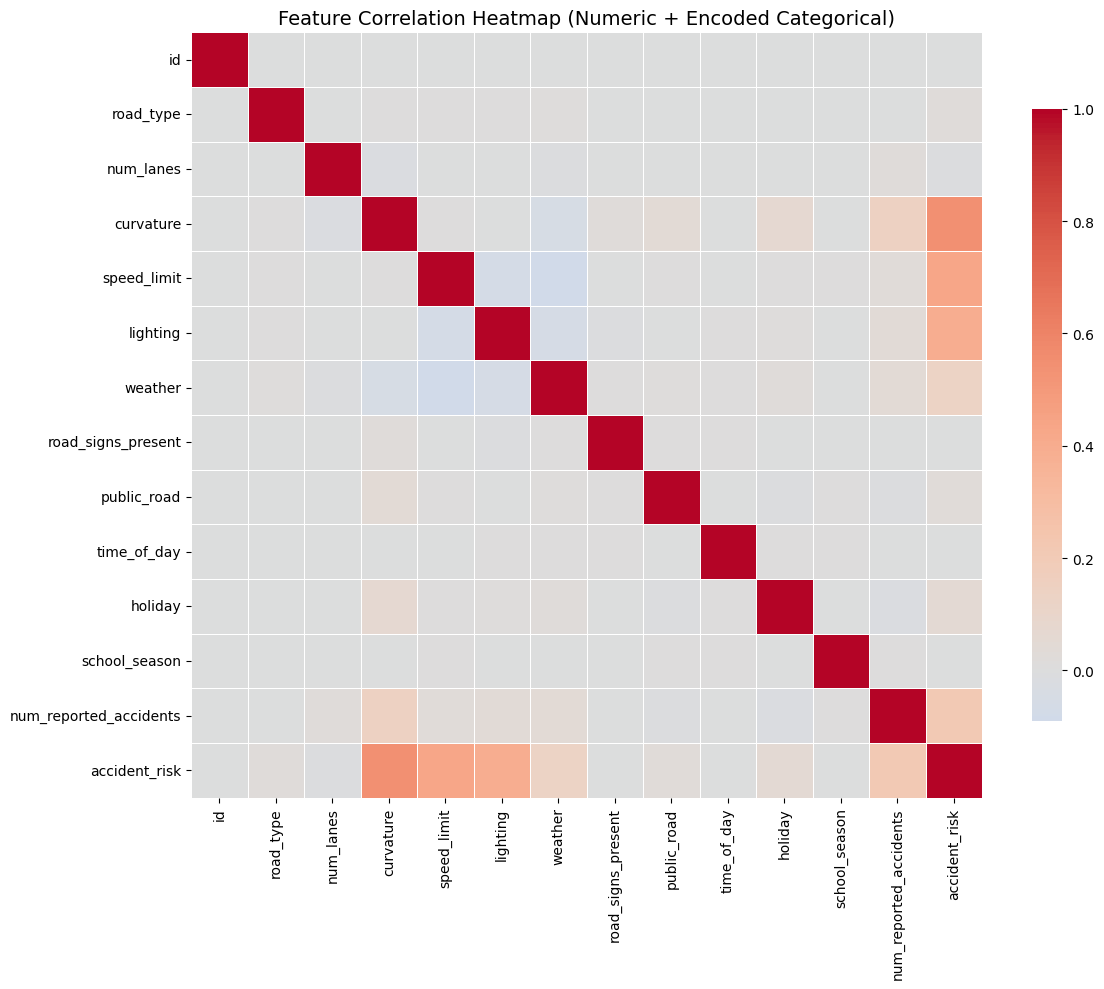

[18:08:58] ✅ Correlation heatmap plotted successfully. Shape: (14, 14)


In [3]:
# ===============================================================
# STEP 2 — Exploratory Data Analysis (EDA)
# ===============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
TARGET = CONFIG["target"]
ID_COL = CONFIG["id_col"]


log("Starting EDA ...")

# ---------------------------------------------------------------
# 2.1: Basic dataset overview
# ---------------------------------------------------------------
log("Basic dataset info:")
display(train.describe(include="all").T.head(10))

log("Checking missing values ...")
missing = train.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].head(10))

# ---------------------------------------------------------------
# 2️.2: Target distribution
# ---------------------------------------------------------------
log("Target variable distribution:")
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(train[TARGET], kde=True, bins=30, color="skyblue", ax=ax)
ax.set_title("Distribution of Accident Risk", fontsize=13)
plt.show()

print(f"Target mean: {train[TARGET].mean():.4f}")
print(f"Target median: {train[TARGET].median():.4f}")
print(f"Target std: {train[TARGET].std():.4f}")

# ---------------------------------------------------------------
# 2.3️: Feature overview
# ---------------------------------------------------------------
features = [c for c in train.columns if c not in [ID_COL, TARGET]]
cat_cols = [c for c in features if train[c].dtype == "object" or train[c].nunique() < 50]
num_cols = [c for c in features if c not in cat_cols]

log(f"Detected {len(cat_cols)} categorical and {len(num_cols)} numerical features.")
log(f"Example categorical features: {cat_cols[:5]}")
log(f"Example numerical features: {num_cols[:5]}")

# ---------------------------------------------------------------
# 2.4️: Categorical feature summary (top few)
# ---------------------------------------------------------------
for c in cat_cols[:3]:  # limit to first 3 for quick inspection
    plt.figure(figsize=(6,3))
    sns.countplot(data=train, x=c, hue=None)
    plt.title(f"{c} distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------
# 2.5️: Numerical feature distributions (top few)
# ---------------------------------------------------------------
for c in num_cols[:3]:
    plt.figure(figsize=(6,3))
    sns.histplot(train[c], bins=30, color="teal", kde=True)
    plt.title(f"{c} distribution")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------
# 2.6: Smart Correlation Heatmap (handles categorical + numeric)
# ---------------------------------------------------------------

# --- Safety check: ensure `encoded` exists ---
if 'encoded' not in locals():
    # If not yet created, use training data + target
    encoded = train.copy()
    # Encode categoricals numerically for correlation
    for c in encoded.select_dtypes(include='object').columns:
        encoded[c] = encoded[c].astype('category').cat.codes
    log("⚙️ Created fallback 'encoded' DataFrame for correlation heatmap.")

# --- Compute correlation matrix including target ---
corr = encoded.corr()

# --- Clean invalid and constant data ---
corr = corr.replace([np.inf, -np.inf], np.nan)  # remove inf
corr = corr.fillna(0)  # replace NaN with 0

# Drop constant columns (no variance)
constant_cols = corr.columns[corr.nunique() <= 1]
if len(constant_cols) > 0:
    log(f"Dropping constant columns from correlation matrix: {list(constant_cols)}")
    corr = corr.drop(columns=constant_cols, errors="ignore")
    corr = corr.drop(index=constant_cols, errors="ignore")

# --- Ensure we have at least one valid column to plot ---
if corr.shape[0] > 1:
    plt.figure(figsize=(12, 10))

    # Safe normalization: compute vmin/vmax explicitly
    vmin, vmax = np.nanmin(corr.values), np.nanmax(corr.values)
    if vmin == vmax:  # avoid division by zero in colormap
        vmin, vmax = -1, 1

    sns.heatmap(
        corr,
        cmap="coolwarm",
        center=0,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )
    plt.title("Feature Correlation Heatmap (Numeric + Encoded Categorical)", fontsize=14)
    plt.tight_layout()
    plt.show()

    log(f"✅ Correlation heatmap plotted successfully. Shape: {corr.shape}")
else:
    log("⚠️ Skipping heatmap: not enough valid columns after cleaning.")


[18:08:58] Analyzing feature–target relationships ...
[18:08:58] Top 10 numeric features correlated with target:


curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
num_lanes                -0.006003
id                        0.000969
dtype: float64

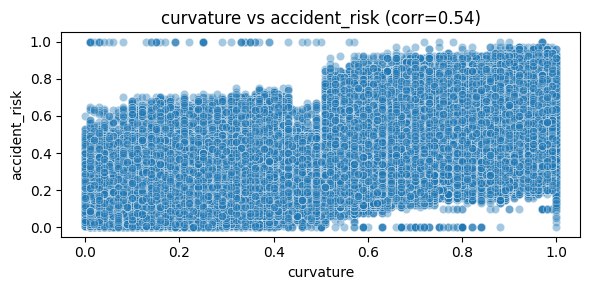

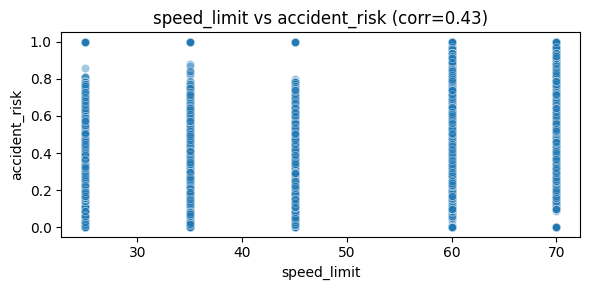

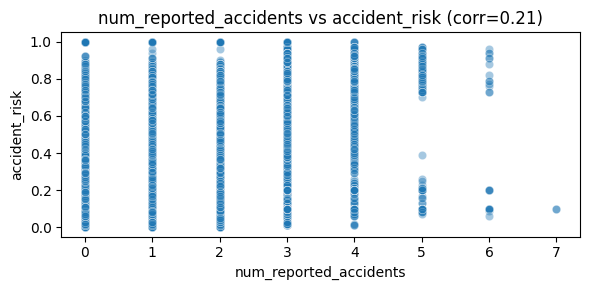

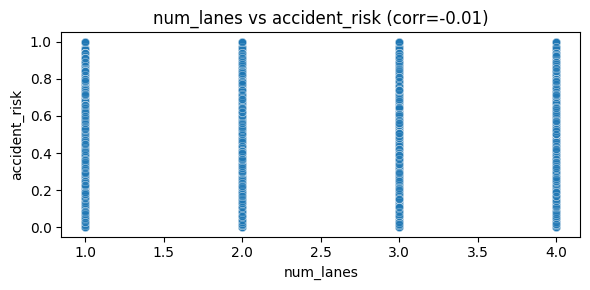

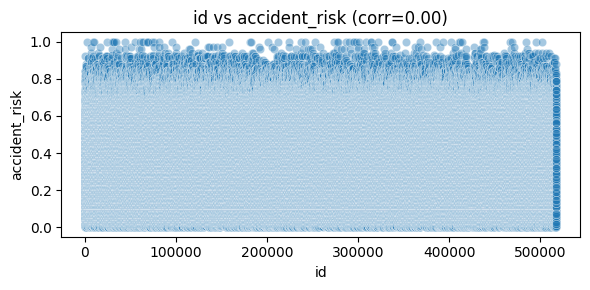

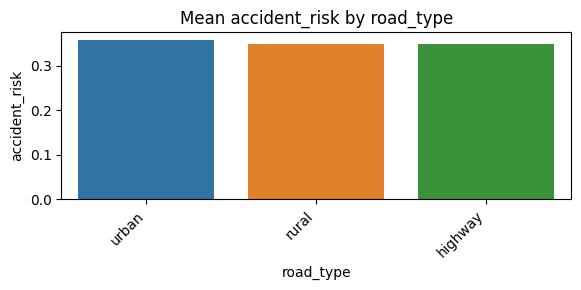

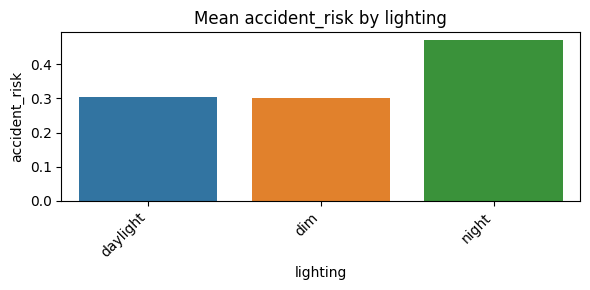

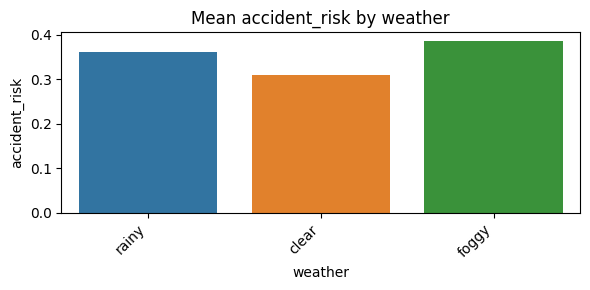

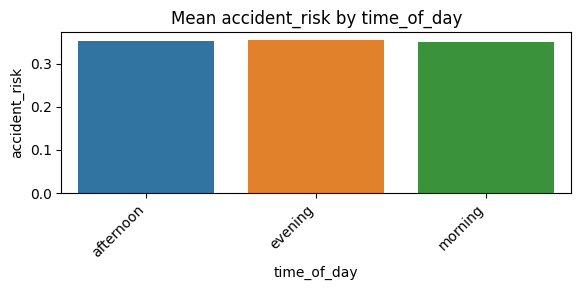

In [4]:
# ---------------------------------------------------------------
# 2.7: Target Relationship Analysis
# ---------------------------------------------------------------
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

log("Analyzing feature–target relationships ...")

TARGET = CONFIG["target"]

# --- 1. Numeric feature relationships ---
num_features = train.select_dtypes(include=[np.number]).columns.drop(TARGET, errors="ignore")

if len(num_features) > 0:
    correlations = {}
    for col in num_features:
        if train[col].nunique() > 1:
            corr_val = train[[col, TARGET]].corr().iloc[0, 1]
            correlations[col] = corr_val

    corr_df = (
        pd.Series(correlations)
        .dropna()
        .sort_values(key=lambda x: abs(x), ascending=False)
        .head(10)
    )

    log("Top 10 numeric features correlated with target:")
    display(corr_df)

    # Plot the top correlated numeric features
    for col in corr_df.index:
        plt.figure(figsize=(6, 3))
        sns.scatterplot(x=train[col], y=train[TARGET], alpha=0.4)
        plt.title(f"{col} vs {TARGET} (corr={corr_df[col]:.2f})")
        plt.tight_layout()
        plt.show()
else:
    log("No numeric features found for target correlation analysis.")

# --- 2. Categorical feature relationships ---
cat_features = train.select_dtypes(include=["object", "category"]).columns

if len(cat_features) > 0:
    for col in cat_features[:5]:  # limit to first 5 for clarity
        plt.figure(figsize=(6, 3))
        sns.barplot(
            data=train,
            x=col,
            y=TARGET,
            estimator=np.mean,
            errorbar=None,
        )
        plt.title(f"Mean {TARGET} by {col}")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
else:
    log("No categorical features found for target mean analysis.")


# Step 3: Feature Engineering and Preprocessing

In this step, we prepare the dataset for modeling:
- Handle missing values using appropriate imputation strategies.
- Encode categorical variables using Label Encoding or One-Hot Encoding.
- Create new derived features (e.g., temporal, interaction-based, or aggregated).
- Normalize or scale numeric features (if needed).
- Split data into features (X) and target (y).
- Prepare cross-validation setup for fair model evaluation.

**Goal:** Transform raw data into machine-learning-friendly format while maximizing predictive power.


In [5]:
# ===============================================================
# STEP 3 — FEATURE ENGINEERING & PREPROCESSING
# ===============================================================

log("Feature Engineering & Preprocessing...")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# 3.1 Separate target and features
# ---------------------------------------------------------------
TARGET = CONFIG["target"]

X = train.drop(columns=[TARGET])
y = train[TARGET]
X_test = test.copy()

# ---------------------------------------------------------------
# 3.2 Identify numeric and categorical columns
# ---------------------------------------------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

log(f"Identified {len(num_cols)} numeric and {len(cat_cols)} categorical columns.")

# ---------------------------------------------------------------
# 3️.3: Rare category grouping (reduces noise & improves generalization)
# ---------------------------------------------------------------
def group_rare_categories(df, cols, threshold=0.01):
    """
    Replace rare categories (below threshold proportion) with 'Other'.
    """
    for c in cols:
        freqs = df[c].value_counts(normalize=True)
        rare_labels = freqs[freqs < threshold].index
        df[c] = df[c].replace(rare_labels, "Other")
    return df

X = group_rare_categories(X, cat_cols)
X_test = group_rare_categories(X_test, cat_cols)

# ---------------------------------------------------------------
# 3.4: Temporal / cyclical feature extraction (if applicable)
# ---------------------------------------------------------------
def extract_time_features(df, time_col):
    """
    Extract time-based features from a datetime column.
    Automatically adds cyclical encodings for hour and month.
    """
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    
    # Cyclical encoding
    for col, max_val in [("hour", 24), ("month", 12)]:
        df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
        df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# Example usage (uncomment if time column exists)
# X = extract_time_features(X, "date_time")
# X_test = extract_time_features(X_test, "date_time")

# ---------------------------------------------------------------
# 3.5️: Handle missing values + scaling + encoding via pipeline
# ---------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# ---------------------------------------------------------------
# 3.6️: Optional: create domain-specific interaction features
# ---------------------------------------------------------------
if "vehicle_speed" in X.columns and "visibility" in X.columns:
    X["speed_visibility_ratio"] = X["vehicle_speed"] / (X["visibility"] + 1)
    X_test["speed_visibility_ratio"] = X_test["vehicle_speed"] / (X_test["visibility"] + 1)
    num_cols.append("speed_visibility_ratio")

log("Feature engineering complete. Proceeding to preprocessing...")

# ---------------------------------------------------------------
# 3.7️: Fit-transform the preprocessor (train → fit, test → transform)
# ---------------------------------------------------------------
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

log(f"✅ Preprocessing complete. "
    f"Train shape: {X_preprocessed.shape}, Test shape: {X_test_preprocessed.shape}")

# ---------------------------------------------------------------
# 3.8️: Optional: get feature names (useful for model interpretation)
# ---------------------------------------------------------------
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feature_{i}" for i in range(X_preprocessed.shape[1])]

log(f"Total engineered features: {len(feature_names)}")

# ---------------------------------------------------------------
# 3.9️: Store for next steps
# ---------------------------------------------------------------
train_processed = pd.DataFrame(X_preprocessed, columns=feature_names)
test_processed = pd.DataFrame(X_test_preprocessed, columns=feature_names)
train_processed[TARGET] = y.reset_index(drop=True)

log("Data ready for model training.")


[18:09:07] Feature Engineering & Preprocessing...
[18:09:07] Identified 5 numeric and 8 categorical columns.
[18:09:08] Feature engineering complete. Proceeding to preprocessing...
[18:09:11] ✅ Preprocessing complete. Train shape: (517754, 25), Test shape: (172585, 25)
[18:09:11] Total engineered features: 25
[18:09:11] Data ready for model training.


[18:09:11] Visualizing engineered feature distributions...


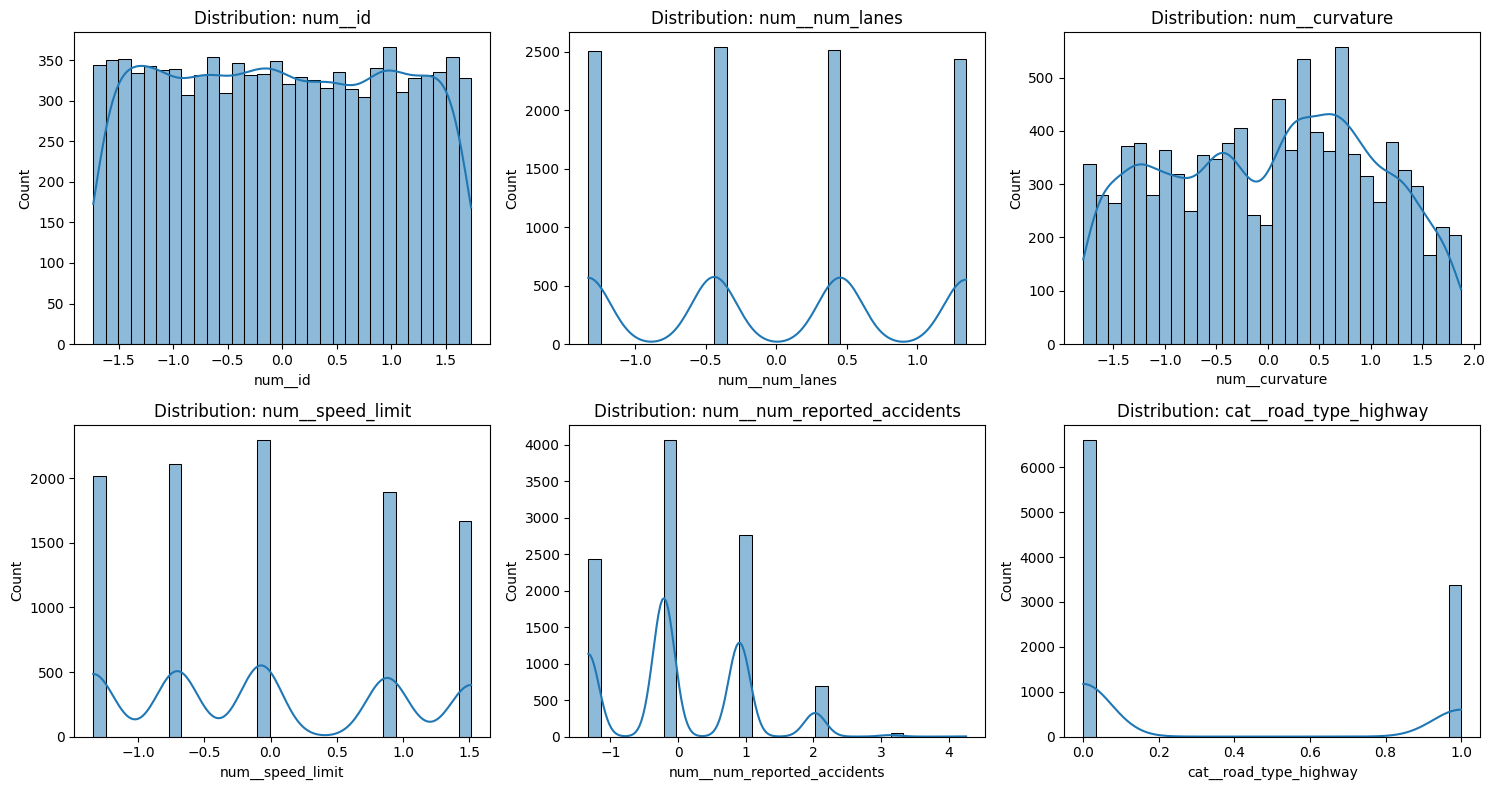

[18:09:13] Plotting correlation heatmap...


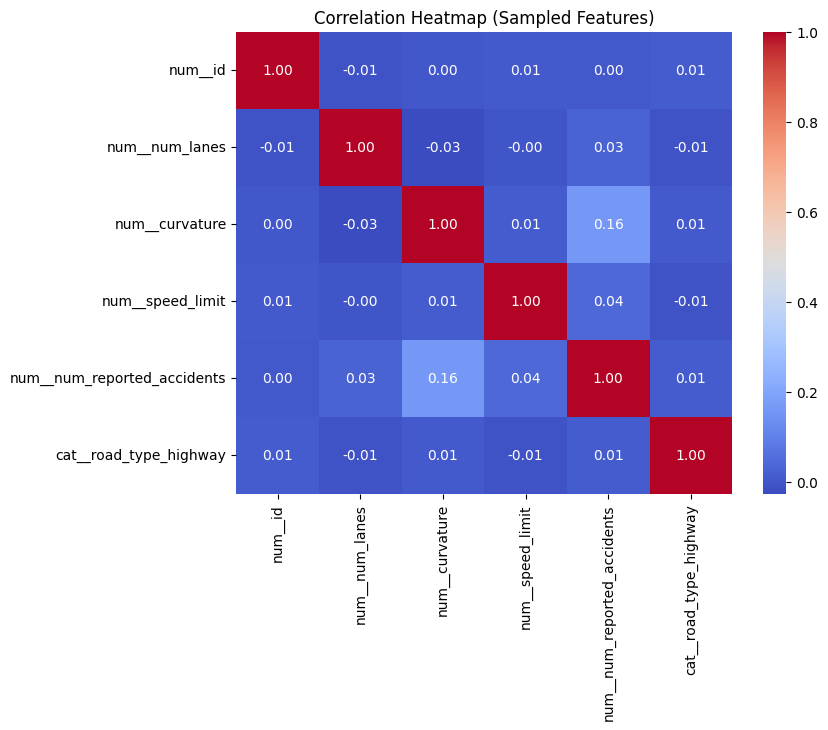

In [6]:
# ===============================================================
# VISUALIZATION for Step-3 (Feature Engineering)
# ===============================================================

log("Visualizing engineered feature distributions...")

# Numeric feature distributions
sampled_train = train_processed.sample(10000, random_state=42) if len(train_processed) > 10000 else train_processed
numeric_features = [col for col in sampled_train.columns if np.issubdtype(sampled_train[col].dtype, np.number)][:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_features):
    sns.histplot(sampled_train[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f"Distribution: {col}")
plt.tight_layout()
plt.show()

# Correlation heatmap
log("Plotting correlation heatmap...")
corr = sampled_train[numeric_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Sampled Features)")
plt.show()

# Categorical feature balance (if any)
cat_features = [c for c in sampled_train.columns if sampled_train[c].dtype == 'object'][:4]
if cat_features:
    fig, axes = plt.subplots(1, len(cat_features), figsize=(5 * len(cat_features), 4))
    axes = np.atleast_1d(axes)
    for i, col in enumerate(cat_features):
        sns.countplot(y=col, data=sampled_train, ax=axes[i])
        axes[i].set_title(f"Category Counts: {col}")
    plt.tight_layout()
    plt.show()


# Step 4: Model Training and Validation (LightGBM Regression)

We train a LightGBM model with K-Fold cross-validation:
- Define model hyperparameters for optimized gradient boosting.
- Use Stratified or Group K-Fold for balanced validation splits.
- Record Out-of-Fold (OOF) predictions to evaluate model stability.
- Track fold-wise and overall RMSE/R² performance.
- Visualize feature importance to interpret key drivers of prediction.

**Goal:** Build a strong gradient boosting baseline and analyze feature influence.


[18:09:13] Starting Model Training & Validation (Regression)...
[18:09:14] 🚀 Training Fold 1/5 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.0560242	valid_1's rmse: 0.0563958
[400]	training's rmse: 0.0557621	valid_1's rmse: 0.0563349
[600]	training's rmse: 0.055548	valid_1's rmse: 0.0563176
Early stopping, best iteration is:
[597]	training's rmse: 0.0555503	valid_1's rmse: 0.0563172
[18:09:35] Fold 1 — RMSE: 0.0563, R²: 0.8851
[18:09:35] 🚀 Training Fold 2/5 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.0560599	valid_1's rmse: 0.0562585
[400]	training's rmse: 0.0557796	valid_1's rmse: 0.0561897
[600]	training's rmse: 0.0555608	valid_1's rmse: 0.056165
[800]	training's rmse: 0.0553704	valid_1's rmse: 0.0561552
Early stopping, best iteration is:
[783]	training's rmse: 0.0553837	valid_1's rmse: 0.0561531
[18:10:02] Fold 2 — RMSE: 0.0562, R²: 0.8862
[18:10:02] 🚀 Training Fold 3/5 ...
Training until val

,fold,RMSE,R2
0,1,0.056317,0.885137
1,2,0.056153,0.886191
2,3,0.056195,0.886623
3,4,0.056076,0.885900
4,5,0.056025,0.886854


[18:11:29] ✅ CV Summary — Mean RMSE: 0.0562, Mean R²: 0.8861
[18:11:29] Overall OOF RMSE: 0.0562, Overall OOF R²: 0.8861


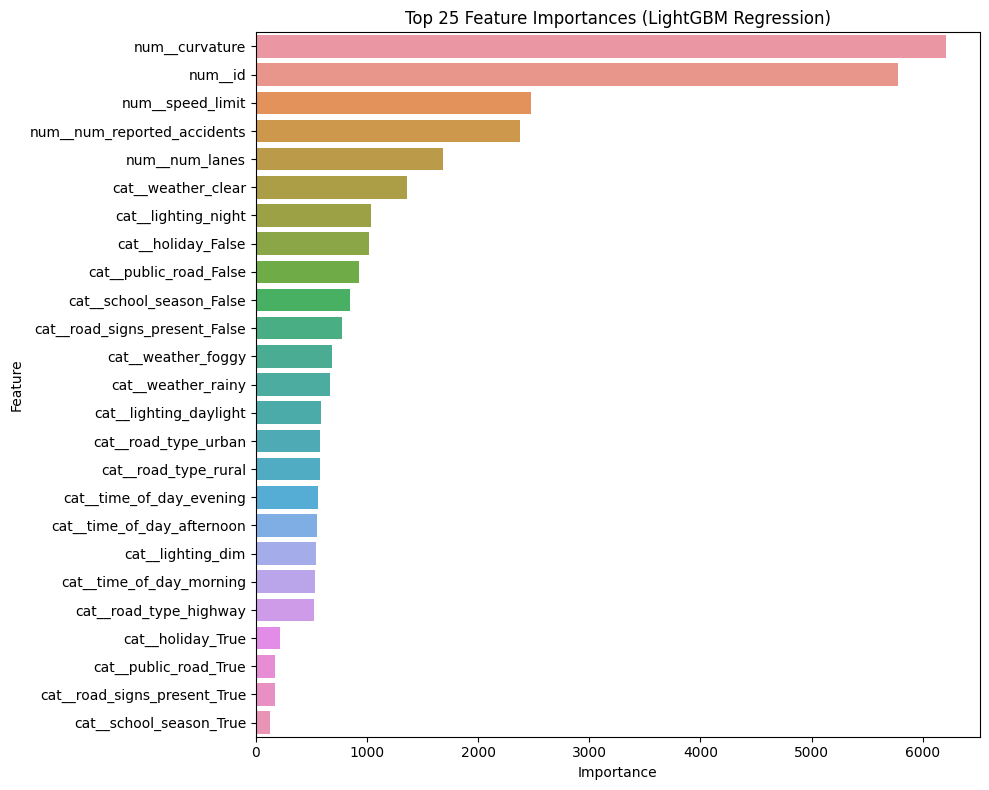

[18:11:30] Saved submission.csv successfully!
[18:11:30] ✅ Regression model training and evaluation finished.


In [7]:
# ===============================================================
# STEP 4 — MODEL TRAINING & VALIDATION (REGRESSION VERSION)
# ===============================================================

log("Starting Model Training & Validation (Regression)...")

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------------------------------------------
# 4.1: Configuration
# ---------------------------------------------------------------
N_SPLITS = CONFIG.get("cv_folds", 5)
SEED = CONFIG.get("seed", 42)
TARGET = CONFIG["target"]

# Extract preprocessed data
X = train_processed.drop(columns=[TARGET])
y = train_processed[TARGET]
X_test = test_processed.copy()

# ---------------------------------------------------------------
# 4.2: Cross-validation setup
# ---------------------------------------------------------------
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
fold_metrics = []

# ---------------------------------------------------------------
# 4.3: LightGBM parameters for regression
# ---------------------------------------------------------------
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": SEED,
}

# ---------------------------------------------------------------
# 4.4: Training loop
# ---------------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    log(f"🚀 Training Fold {fold}/{N_SPLITS} ...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200)
    ],
)

    # Validation predictions
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    oof_preds[val_idx] = val_pred

    # Test predictions (averaged)
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / N_SPLITS

    # Evaluation metrics
    rmse = mean_squared_error(y_val, val_pred, squared=False)
    r2 = r2_score(y_val, val_pred)

    fold_metrics.append({
        "fold": fold,
        "RMSE": rmse,
        "R2": r2,
    })
    log(f"Fold {fold} — RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ---------------------------------------------------------------
# 4.5: Cross-validation summary
# ---------------------------------------------------------------
metrics_df = pd.DataFrame(fold_metrics)
log("Cross-validation results:")
display(metrics_df)

mean_rmse = metrics_df["RMSE"].mean()
mean_r2 = metrics_df["R2"].mean()

log(f"✅ CV Summary — Mean RMSE: {mean_rmse:.4f}, Mean R²: {mean_r2:.4f}")

# ---------------------------------------------------------------
# 4.6: OOF performance evaluation
# ---------------------------------------------------------------
oof_rmse = mean_squared_error(y, oof_preds, squared=False)
oof_r2 = r2_score(y, oof_preds)
log(f"Overall OOF RMSE: {oof_rmse:.4f}, Overall OOF R²: {oof_r2:.4f}")

# ---------------------------------------------------------------
# 4.7: Feature importance visualization
# ---------------------------------------------------------------
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importance(),
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(25), x="Importance", y="Feature")
plt.title("Top 25 Feature Importances (LightGBM Regression)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 4.8: Save predictions for submission
# ---------------------------------------------------------------
submission = pd.DataFrame({
    "id": test.index,
    TARGET: test_preds
})
submission.to_csv("submission.csv", index=False)
log("Saved submission.csv successfully!")

log("✅ Regression model training and evaluation finished.")


[18:11:30] Visualizing Regression Performance...
[18:11:30] Overall OOF RMSE: 0.0562, Overall OOF R²: 0.8861


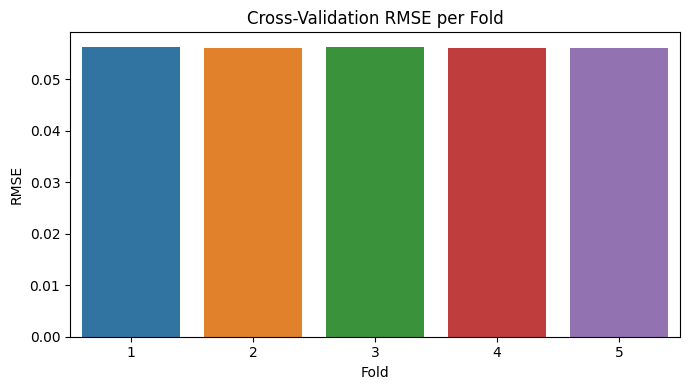

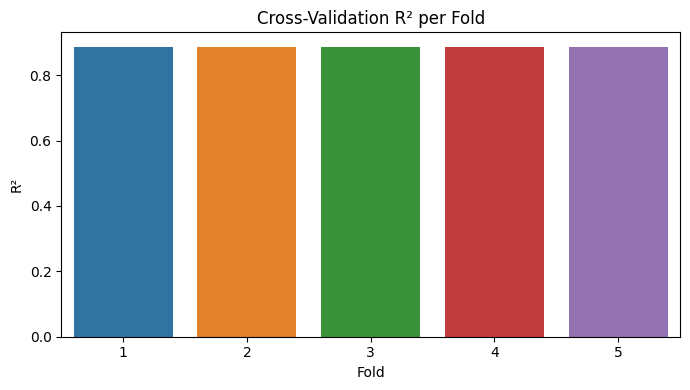

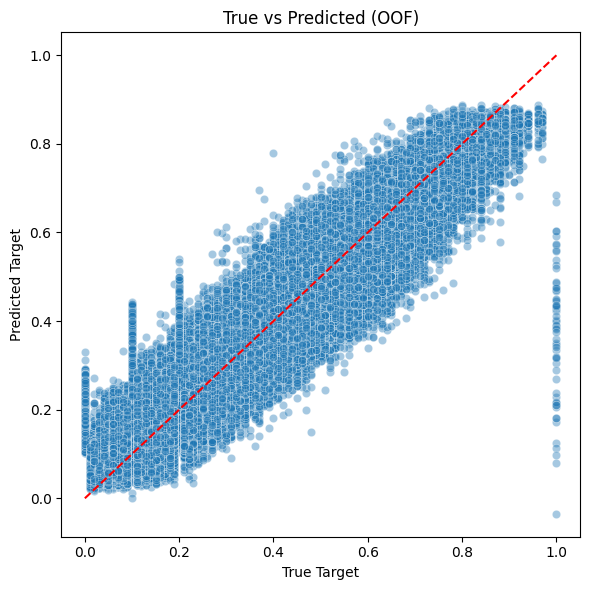

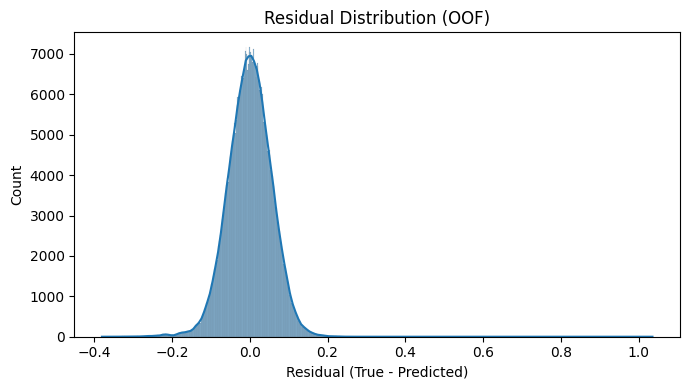

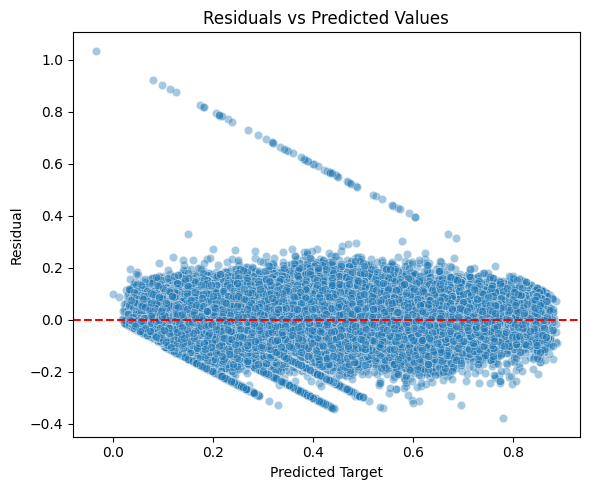

[18:11:37] ✅ Regression performance visualizations generated.


In [8]:
# ===============================================================
# MODEL DIAGNOSTICS & VISUALIZATION (REGRESSION)
# ===============================================================

log("Visualizing Regression Performance...")

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Overall performance summary
oof_rmse = mean_squared_error(y, oof_preds, squared=False)
oof_r2 = r2_score(y, oof_preds)
log(f"Overall OOF RMSE: {oof_rmse:.4f}, Overall OOF R²: {oof_r2:.4f}")

# ---------------------------------------------------------------
# CV metric variance across folds
# ---------------------------------------------------------------
plt.figure(figsize=(7, 4))
sns.barplot(x="fold", y="RMSE", data=metrics_df)
plt.title("Cross-Validation RMSE per Fold")
plt.ylabel("RMSE")
plt.xlabel("Fold")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.barplot(x="fold", y="R2", data=metrics_df)
plt.title("Cross-Validation R² per Fold")
plt.ylabel("R²")
plt.xlabel("Fold")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# True vs Predicted scatter (OOF)
# ---------------------------------------------------------------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=oof_preds, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title("True vs Predicted (OOF)")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Residual analysis
# ---------------------------------------------------------------
residuals = y - oof_preds

# Residual distribution
plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (OOF)")
plt.xlabel("Residual (True - Predicted)")
plt.tight_layout()
plt.show()

# Residuals vs Predicted (to check heteroscedasticity)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=oof_preds, y=residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Target")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

log("✅ Regression performance visualizations generated.")

[18:11:37] Interpreting model with SHAP values...
[18:11:57] Computed SHAP values for 2000 samples and 25 features.


The figure layout has changed to tight


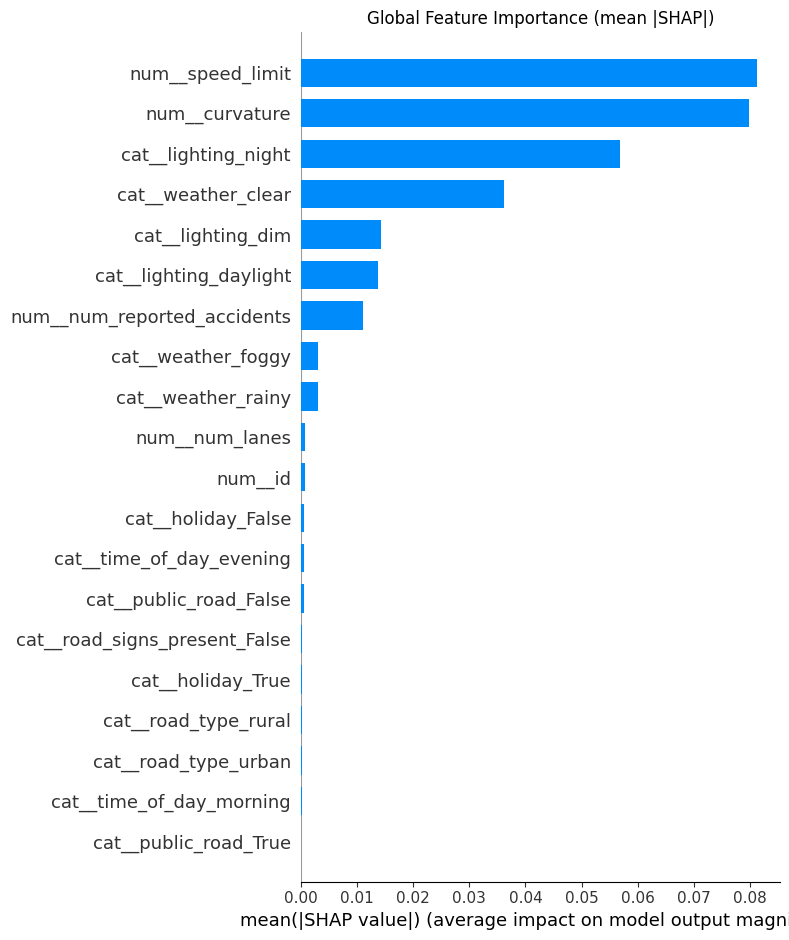

The figure layout has changed to tight


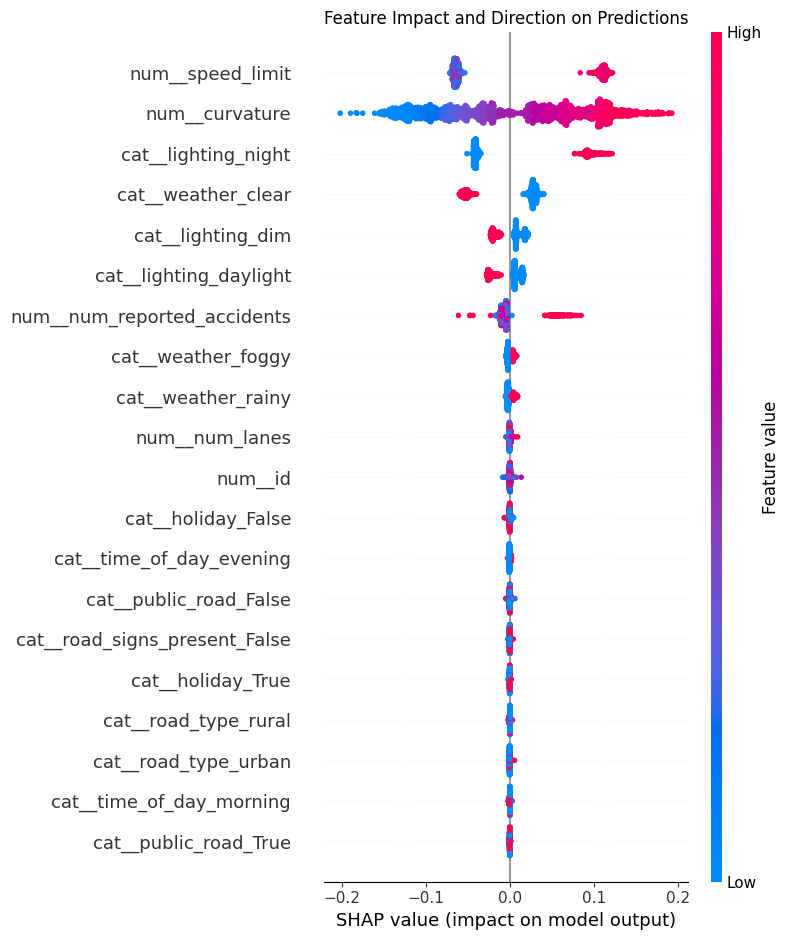

[18:11:58] Generating SHAP dependence plots for top features: ['num__curvature', 'num__id', 'num__speed_limit']


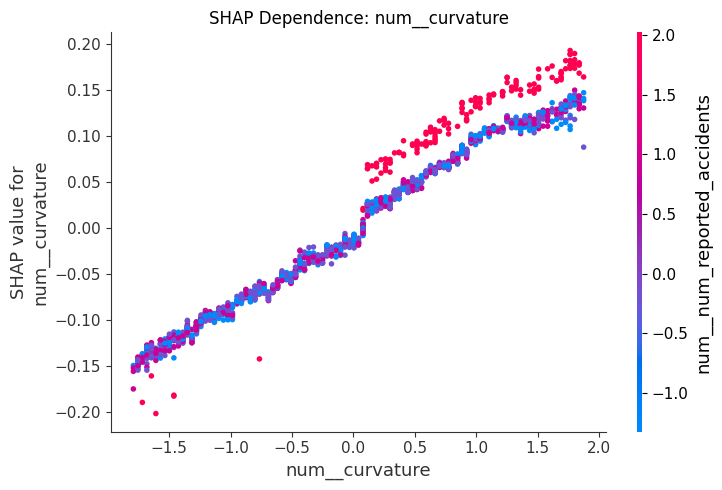

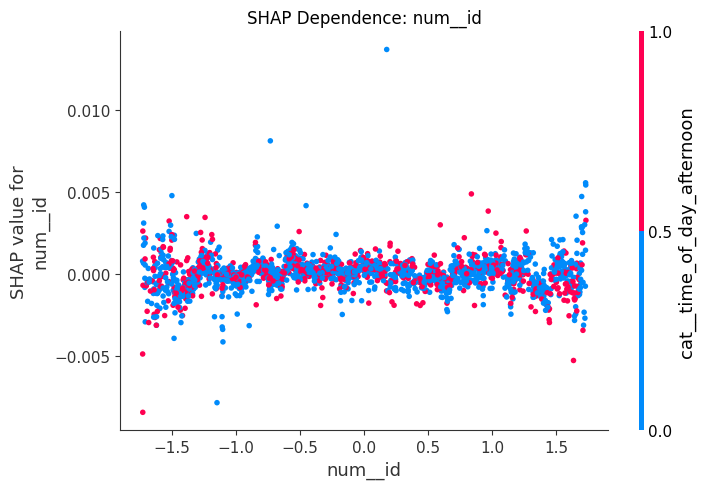

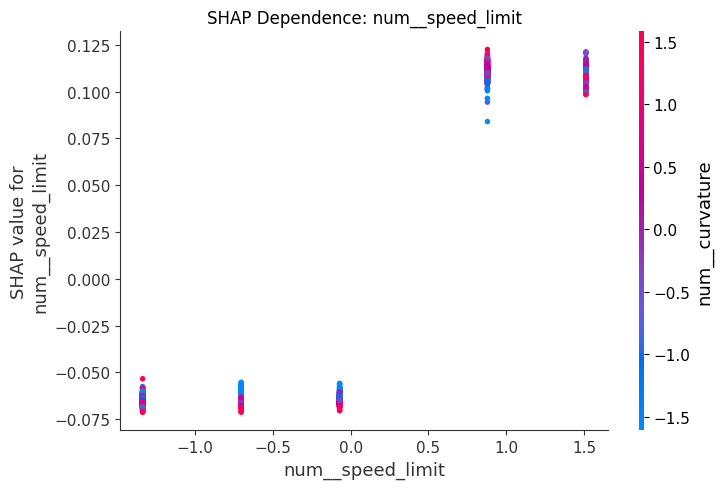

[18:12:00] ✅ SHAP interpretability visualizations generated.


In [9]:
# ===============================================================
# MODEL INTERPRETABILITY WITH SHAP (Shapely Additive Explanation)
# ===============================================================

log("Interpreting model with SHAP values...")

# Install and import SHAP
try:
    import shap
except ImportError:
    !pip install shap -q
    import shap

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Prepare explainer on a sample
# ---------------------------------------------------------------
# For speed, use a representative subset
SAMPLE_SIZE = min(2000, len(X))
X_sample = X.sample(SAMPLE_SIZE, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

log(f"Computed SHAP values for {SAMPLE_SIZE} samples and {X_sample.shape[1]} features.")

# ---------------------------------------------------------------
# Global Feature Importance (SHAP summary)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Detailed Feature Impact (SHAP beeswarm)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Feature Impact and Direction on Predictions")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Feature Dependence Plots (top features)
# ---------------------------------------------------------------
top_feats = feature_importance["Feature"].head(3).tolist()
log(f"Generating SHAP dependence plots for top features: {top_feats}")

for feat in top_feats:
    shap.dependence_plot(feat, shap_values, X_sample, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout()
    plt.show()

log("✅ SHAP interpretability visualizations generated.")


# Step 5: Model Training and Validation (XGBoost Regression) 

Next, we train an XGBoost model using the same CV setup:
- Define model parameters for tree boosting.
- Compare its performance with LightGBM using OOF RMSE and R².
- Store fold predictions for future ensembling.
- Review top contributing features using feature importance charts.

**Goal:** Cross-check model robustness and performance consistency across algorithms.


[18:12:00] Model Training & Validation (XGBoost Regression)...
[18:12:00] Using XGBoost version: 2.0.3
[18:12:00] 🚀 Training Fold 1/5 ...
[0]	train-rmse:0.15920	valid-rmse:0.15892
[200]	train-rmse:0.05576	valid-rmse:0.05629
[400]	train-rmse:0.05543	valid-rmse:0.05627
[600]	train-rmse:0.05515	valid-rmse:0.05627
[620]	train-rmse:0.05513	valid-rmse:0.05627
[18:12:45] Fold 1 — RMSE: 0.0563, R²: 0.8853
[18:12:45] 🚀 Training Fold 2/5 ...
[0]	train-rmse:0.15913	valid-rmse:0.15918
[200]	train-rmse:0.05580	valid-rmse:0.05615
[400]	train-rmse:0.05546	valid-rmse:0.05612
[525]	train-rmse:0.05528	valid-rmse:0.05613
[18:13:24] Fold 2 — RMSE: 0.0561, R²: 0.8863
[18:13:24] 🚀 Training Fold 3/5 ...
[0]	train-rmse:0.15903	valid-rmse:0.15959
[200]	train-rmse:0.05577	valid-rmse:0.05619
[400]	train-rmse:0.05543	valid-rmse:0.05617
[480]	train-rmse:0.05531	valid-rmse:0.05617
[18:14:16] Fold 3 — RMSE: 0.0562, R²: 0.8867
[18:14:16] 🚀 Training Fold 4/5 ...
[0]	train-rmse:0.15924	valid-rmse:0.15876
[200]	train-rm

,fold,RMSE,R2
0,1,0.056265,0.885349
1,2,0.056122,0.886317
2,3,0.056168,0.886733
3,4,0.056036,0.886062
4,5,0.055960,0.887113


[18:15:42] ✅ CV Summary — Mean RMSE: 0.0561, Mean R²: 0.8863


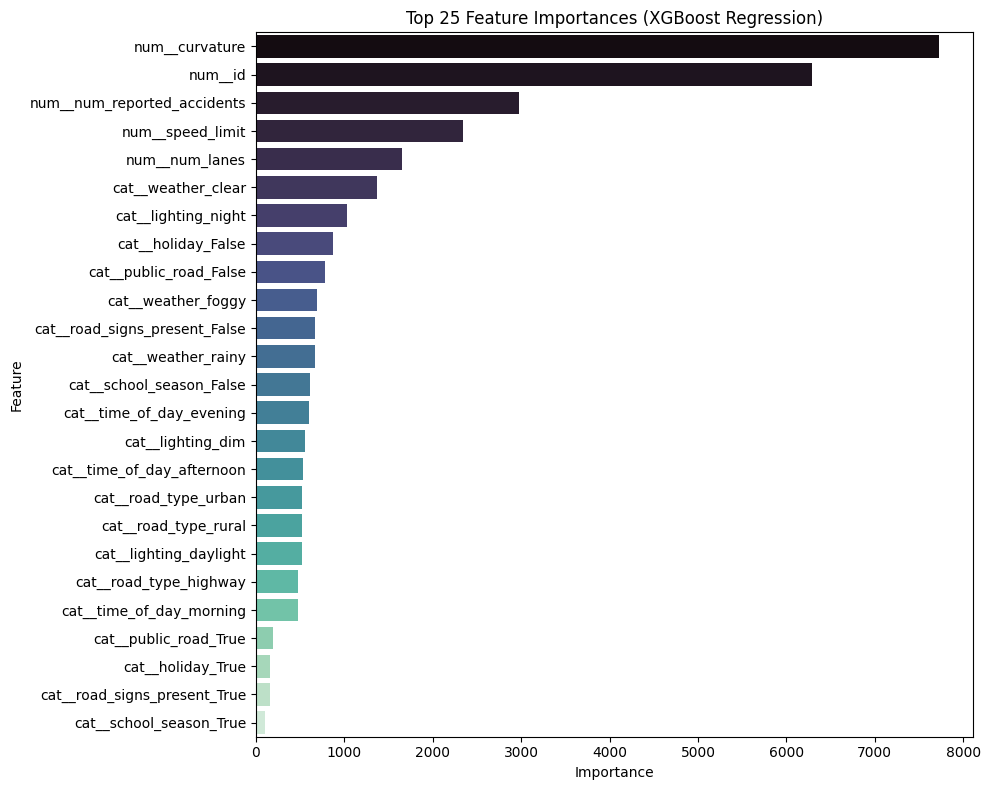

[18:15:43] Saved submission_xgb.csv successfully!
[18:15:43] ✅ XGBoost regression training and evaluation finished.


In [10]:
# ===============================================================
# STEP 5 — MODEL TRAINING & VALIDATION (XGBOOST REGRESSION)
# ===============================================================

log("Model Training & Validation (XGBoost Regression)...")

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from packaging import version

log(f"Using XGBoost version: {xgb.__version__}")

# ---------------------------------------------------------------
# 5.1: Configuration
# ---------------------------------------------------------------
N_SPLITS = CONFIG.get("cv_folds", 5)
SEED = CONFIG.get("seed", 42)
TARGET = CONFIG["target"]

X = train_processed.drop(columns=[TARGET])
y = train_processed[TARGET]
X_test = test_processed.copy()

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_preds_xgb = np.zeros(len(X))
test_preds_xgb = np.zeros(len(X_test))
fold_metrics_xgb = []

# ---------------------------------------------------------------
# 5.2: XGBoost parameters (regression)
# ---------------------------------------------------------------
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": SEED,
    "tree_method": "hist",   # Faster on CPUs
}

# ---------------------------------------------------------------
# 5.3: Training loop with CV
# ---------------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    log(f"🚀 Training Fold {fold}/{N_SPLITS} ...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    evals = [(dtrain, "train"), (dval, "valid")]

    model_xgb = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=200
    )

    # Predictions
    val_pred = model_xgb.predict(dval, iteration_range=(0, model_xgb.best_iteration + 1))
    oof_preds_xgb[val_idx] = val_pred
    test_preds_xgb += model_xgb.predict(dtest, iteration_range=(0, model_xgb.best_iteration + 1)) / N_SPLITS

    # Metrics
    rmse = mean_squared_error(y_val, val_pred, squared=False)
    r2 = r2_score(y_val, val_pred)
    fold_metrics_xgb.append({"fold": fold, "RMSE": rmse, "R2": r2})

    log(f"Fold {fold} — RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ---------------------------------------------------------------
# 5.4: Cross-validation summary
# ---------------------------------------------------------------
metrics_df_xgb = pd.DataFrame(fold_metrics_xgb)
log("Cross-validation results (XGBoost):")
display(metrics_df_xgb)

mean_rmse_xgb = metrics_df_xgb["RMSE"].mean()
mean_r2_xgb = metrics_df_xgb["R2"].mean()
log(f"✅ CV Summary — Mean RMSE: {mean_rmse_xgb:.4f}, Mean R²: {mean_r2_xgb:.4f}")

# ---------------------------------------------------------------
# 5.5: Feature importance
# ---------------------------------------------------------------
xgb_importance = model_xgb.get_score(importance_type="weight")
xgb_importance_df = (
    pd.DataFrame.from_dict(xgb_importance, orient="index", columns=["Importance"])
    .reset_index()
    .rename(columns={"index": "Feature"})
    .sort_values(by="Importance", ascending=False)
)

plt.figure(figsize=(10, 8))
sns.barplot(data=xgb_importance_df.head(25), x="Importance", y="Feature", palette="mako")
plt.title("Top 25 Feature Importances (XGBoost Regression)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5.6: Save submission
# ---------------------------------------------------------------
submission_xgb = pd.DataFrame({
    "id": test.index,
    TARGET: test_preds_xgb
})
submission_xgb.to_csv("submission_xgb.csv", index=False)
log("Saved submission_xgb.csv successfully!")

log("✅ XGBoost regression training and evaluation finished.")


[18:15:43] Visualizing XGBoost Regression Performance...
[18:15:43] Overall XGBoost OOF RMSE: 0.0561, Overall R²: 0.8863


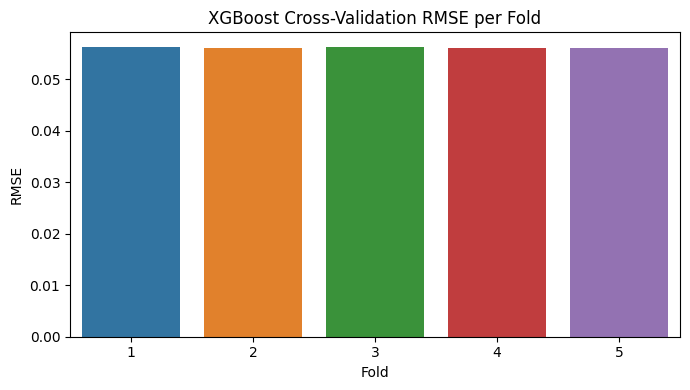

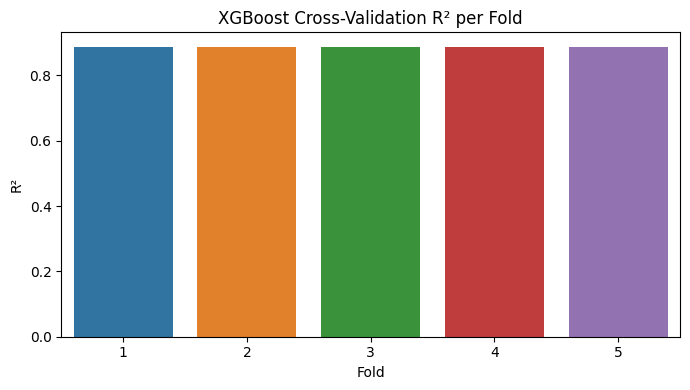

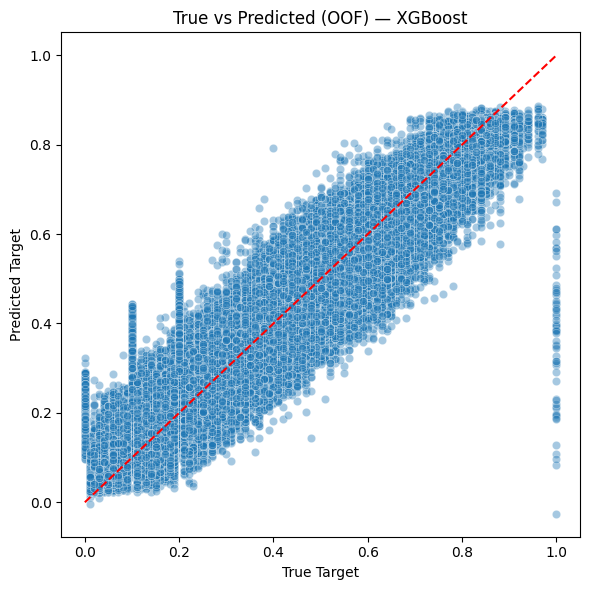

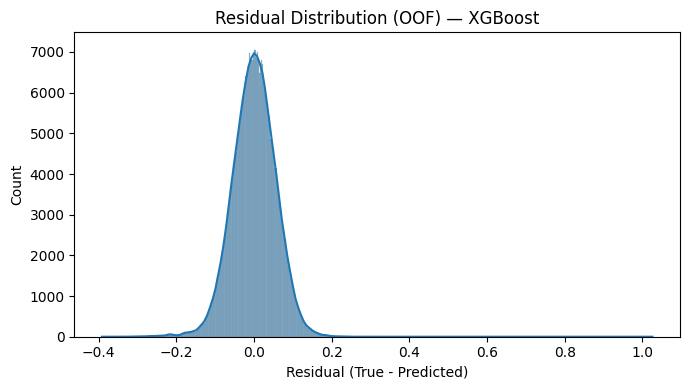

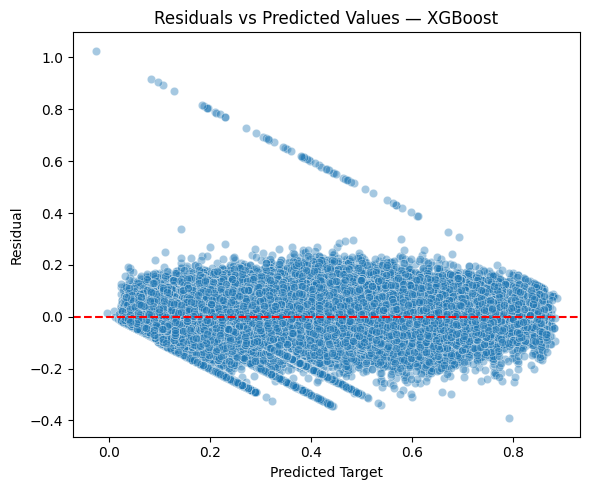

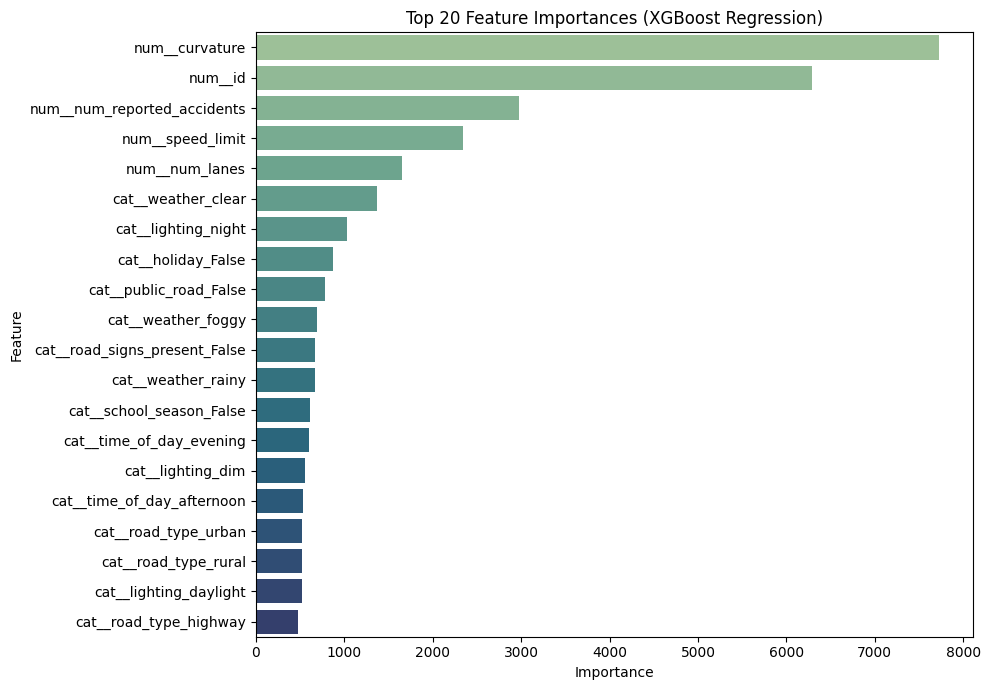

[18:15:51] ✅ XGBoost regression visualizations generated.


In [11]:
# ===============================================================
# MODEL DIAGNOSTICS & VISUALIZATION (XGBOOST)
# ===============================================================

log("Visualizing XGBoost Regression Performance...")

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Overall OOF performance
oof_rmse_xgb = mean_squared_error(y, oof_preds_xgb, squared=False)
oof_r2_xgb = r2_score(y, oof_preds_xgb)
log(f"Overall XGBoost OOF RMSE: {oof_rmse_xgb:.4f}, Overall R²: {oof_r2_xgb:.4f}")

# ---------------------------------------------------------------
# CV metric variance across folds
# ---------------------------------------------------------------
plt.figure(figsize=(7, 4))
sns.barplot(x="fold", y="RMSE", data=metrics_df_xgb)
plt.title("XGBoost Cross-Validation RMSE per Fold")
plt.ylabel("RMSE")
plt.xlabel("Fold")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.barplot(x="fold", y="R2", data=metrics_df_xgb)
plt.title("XGBoost Cross-Validation R² per Fold")
plt.ylabel("R²")
plt.xlabel("Fold")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# True vs Predicted (OOF)
# ---------------------------------------------------------------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=oof_preds_xgb, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title("True vs Predicted (OOF) — XGBoost")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Residual analysis
# ---------------------------------------------------------------
residuals_xgb = y - oof_preds_xgb

plt.figure(figsize=(7, 4))
sns.histplot(residuals_xgb, kde=True)
plt.title("Residual Distribution (OOF) — XGBoost")
plt.xlabel("Residual (True - Predicted)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x=oof_preds_xgb, y=residuals_xgb, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values — XGBoost")
plt.xlabel("Predicted Target")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Feature importance visualization (Top 20)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 7))
sns.barplot(data=xgb_importance_df.head(20), x="Importance", y="Feature", palette="crest")
plt.title("Top 20 Feature Importances (XGBoost Regression)")
plt.tight_layout()
plt.show()

log("✅ XGBoost regression visualizations generated.")

In [12]:
print("          MODEL COMPARISON        ")
print(f"LightGBM  | Mean RMSE: {mean_rmse:.4f} | R²: {mean_r2:.4f}")
print(f"XGBoost   | Mean RMSE: {mean_rmse_xgb:.4f} | R²: {mean_r2_xgb:.4f}")
print(f"LightGBM  | OOF RMSE:  {oof_rmse:.4f} | OOF R²: {oof_r2:.4f}")
print(f"XGBoost   | OOF RMSE:  {oof_rmse_xgb:.4f} | OOF R²: {oof_r2_xgb:.4f}")

          MODEL COMPARISON        
LightGBM  | Mean RMSE: 0.0562 | R²: 0.8861
XGBoost   | Mean RMSE: 0.0561 | R²: 0.8863
LightGBM  | OOF RMSE:  0.0562 | OOF R²: 0.8861
XGBoost   | OOF RMSE:  0.0561 | OOF R²: 0.8863


[18:15:51] Interpreting XGBoost Regression Model with SHAP...
[18:16:02] Computed SHAP values for 2000 samples and 25 features.


The figure layout has changed to tight


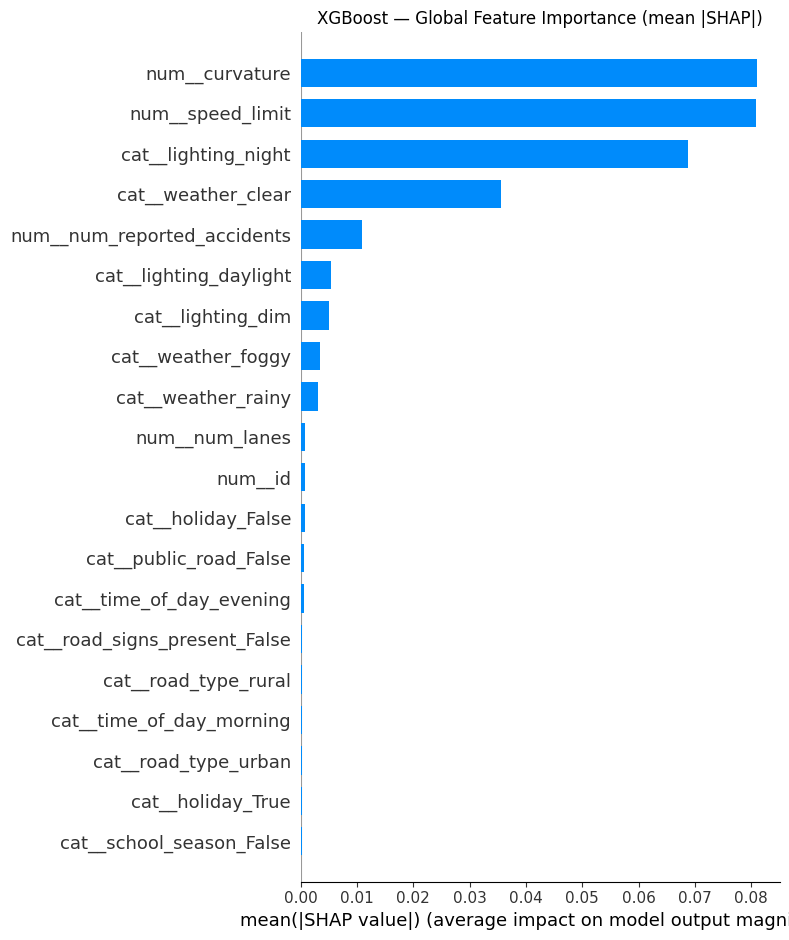

The figure layout has changed to tight


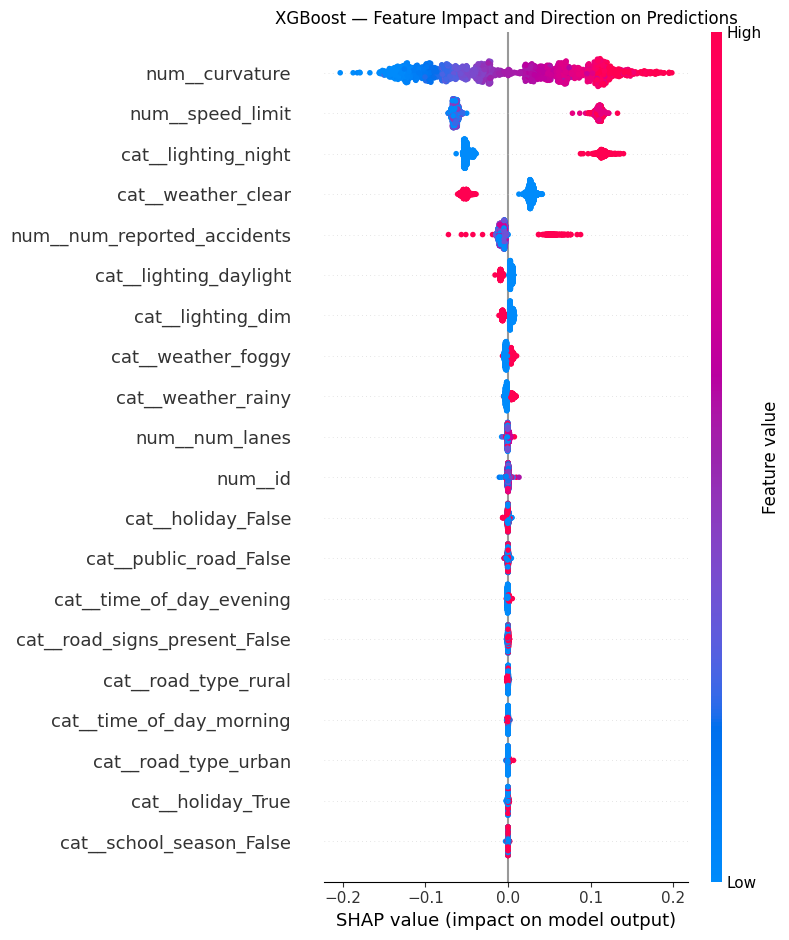

[18:16:03] Generating SHAP dependence plots for top features: ['num__curvature', 'num__id', 'num__num_reported_accidents']


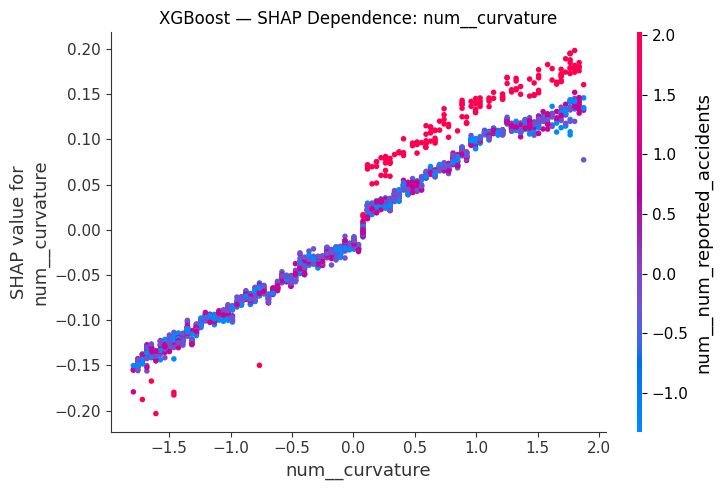

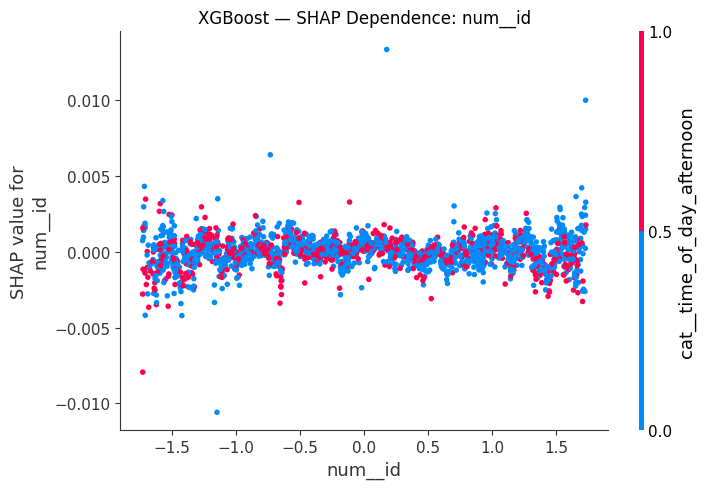

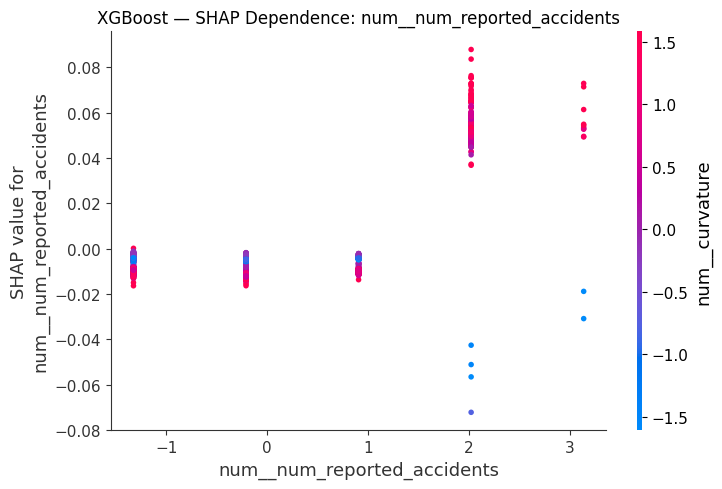

[18:16:04] ✅ SHAP interpretability visualizations generated for XGBoost.


In [13]:
# ===============================================================
# MODEL INTERPRETABILITY WITH SHAP (XGBOOST)
# ===============================================================

log("Interpreting XGBoost Regression Model with SHAP...")

# 1️⃣ Import / install SHAP
try:
    import shap
except ImportError:
    !pip install shap -q
    import shap

import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------
# 2️⃣ Prepare a sample for explanation
# ---------------------------------------------------------------
SAMPLE_SIZE = min(2000, len(X))
X_sample = X.sample(SAMPLE_SIZE, random_state=42)

# Create DMatrix for XGBoost sample
dX_sample = xgb.DMatrix(X_sample)

# ---------------------------------------------------------------
# 3️⃣ Initialize SHAP explainer
# ---------------------------------------------------------------
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_sample)

log(f"Computed SHAP values for {SAMPLE_SIZE} samples and {X_sample.shape[1]} features.")

# ---------------------------------------------------------------
# 4️⃣ Global importance (mean |SHAP|)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_sample, plot_type="bar", show=False)
plt.title("XGBoost — Global Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5️⃣ Beeswarm plot (feature impact and direction)
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_sample, show=False)
plt.title("XGBoost — Feature Impact and Direction on Predictions")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 6️⃣ Dependence plots (top correlated features)
# ---------------------------------------------------------------
top_feats_xgb = xgb_importance_df["Feature"].head(3).tolist()
log(f"Generating SHAP dependence plots for top features: {top_feats_xgb}")

for feat in top_feats_xgb:
    shap.dependence_plot(feat, shap_values_xgb, X_sample, show=False)
    plt.title(f"XGBoost — SHAP Dependence: {feat}")
    plt.tight_layout()
    plt.show()

log("✅ SHAP interpretability visualizations generated for XGBoost.")


# Step 6: Model Comparison and Ensemble

We combine multiple model predictions to improve generalization:
- Average predictions from LightGBM and XGBoost (simple ensemble).
- Optionally, use weighted averaging if one model performs better.
- Compute ensemble RMSE/R² on OOF data.
- Visualize improvement over individual models.

**Goal:** Leverage model diversity to reduce variance and achieve better leaderboard stability.

**Visualization of Model Predictions**

Here, we:
- Plot distribution of predictions from all models.
- Compare predicted vs. actual values (scatter plot or regression line).
- Evaluate residual patterns to check model bias.
- Identify underfitting or overfitting visually.

**Goal:** Validate that predictions are reasonable and unbiased across feature space.


[18:16:05] Comparing models and building ensemble...


,Model,Mean RMSE,OOF RMSE,Mean R²,OOF R²
1,XGBoost,0.056110,0.056110,0.886315,0.886318
0,LightGBM,0.056153,0.056153,0.886141,0.886144


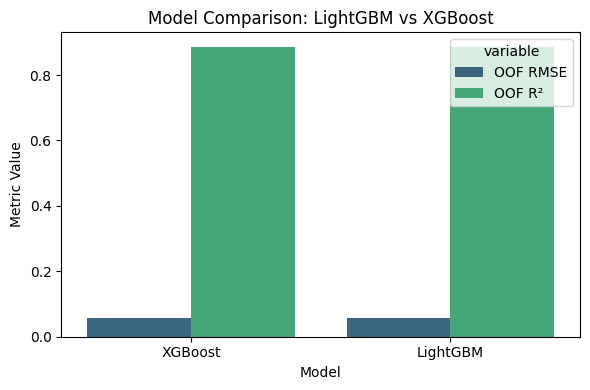

[18:16:05] Creating simple averaged ensemble...
[18:16:05] ✅ Ensemble OOF RMSE: 0.0561, R²: 0.8863
[18:16:05] ✅ Weighted Ensemble OOF RMSE: 0.0561, R²: 0.8863


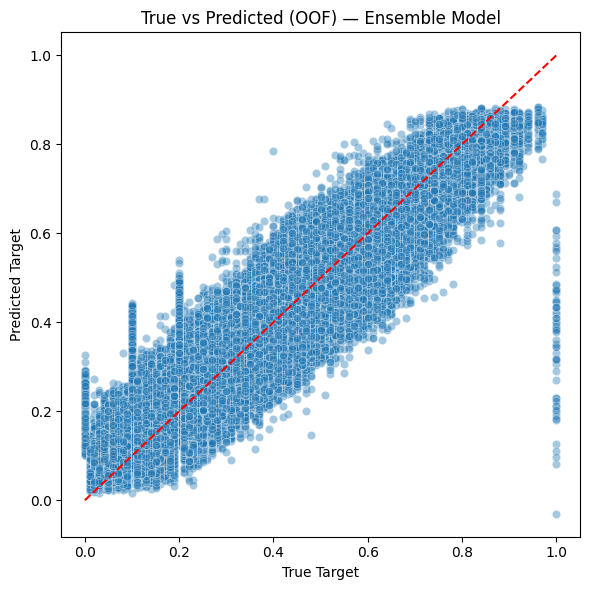

[18:16:07] ✅ Saved submission_ensemble.csv successfully!
[18:16:07] 🎯 Ensemble built and evaluated.


In [14]:
# ===============================================================
# STEP 6 — MODEL COMPARISON & ENSEMBLE
# ===============================================================

log("Comparing models and building ensemble...")

# ---------------------------------------------------------------
# 6.1: Model performance summary table
# ---------------------------------------------------------------
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "Mean RMSE": [mean_rmse, mean_rmse_xgb],
    "OOF RMSE": [oof_rmse, oof_rmse_xgb],
    "Mean R²": [mean_r2, mean_r2_xgb],
    "OOF R²": [oof_r2, oof_r2_xgb]
}).sort_values("OOF RMSE")

display(comparison_df)

plt.figure(figsize=(6, 4))
sns.barplot(data=comparison_df.melt(id_vars="Model", value_vars=["OOF RMSE", "OOF R²"]),
            x="Model", y="value", hue="variable", palette="viridis")
plt.title("Model Comparison: LightGBM vs XGBoost")
plt.ylabel("Metric Value")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 6.2: Ensemble prediction (simple average)
# ---------------------------------------------------------------
log("Creating simple averaged ensemble...")

ensemble_oof = (oof_preds + oof_preds_xgb) / 2
ensemble_test = (test_preds + test_preds_xgb) / 2

ensemble_rmse = mean_squared_error(y, ensemble_oof, squared=False)
ensemble_r2 = r2_score(y, ensemble_oof)

log(f"✅ Ensemble OOF RMSE: {ensemble_rmse:.4f}, R²: {ensemble_r2:.4f}")

# ---------------------------------------------------------------
# 6.3: Weighted ensemble (optional tuning)
# ---------------------------------------------------------------
# You can manually adjust these weights if one model performs better
w_lgb = 0.6
w_xgb = 0.4

weighted_oof = w_lgb * oof_preds + w_xgb * oof_preds_xgb
weighted_test = w_lgb * test_preds + w_xgb * test_preds_xgb

weighted_rmse = mean_squared_error(y, weighted_oof, squared=False)
weighted_r2 = r2_score(y, weighted_oof)

log(f"✅ Weighted Ensemble OOF RMSE: {weighted_rmse:.4f}, R²: {weighted_r2:.4f}")

# ---------------------------------------------------------------
# 6.4: True vs Predicted (Ensemble)
# ---------------------------------------------------------------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y, y=ensemble_oof, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title("True vs Predicted (OOF) — Ensemble Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 6.5: Save ensemble submission
# ---------------------------------------------------------------
submission_ensemble = pd.DataFrame({
    "id": test.index,
    TARGET: ensemble_test
})
submission_ensemble.to_csv("submission_ensemble.csv", index=False)

log("✅ Saved submission_ensemble.csv successfully!")
log("🎯 Ensemble built and evaluated.")


# Final Step: Prediction and Submission file

In this final section, we:
- Save predictions from all three models (LightGBM, XGBoost, Ensemble).
- Automatically compare OOF metrics (RMSE, R²) to identify the best model.
- Save the best model's predictions as **`submission.csv`** — ready for Kaggle upload.
- Optionally, zip all files for record keeping.
- Display a summary of results and leaderboard expectations.

**Goal:** Prepare a clean, reproducible, and leaderboard-ready submission file.


In [15]:
# ===============================================================
# FINAL STEP — AUTO SELECT BEST MODEL AND SAVE submission.csv
# ===============================================================

import zipfile
import datetime
from pathlib import Path

def log(msg: str):
    """Print timestamped log messages for cleaner outputs."""
    print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] {msg}")

log("🚀 Starting final Kaggle submission step...")

# Create a timestamped output directory
output_dir = Path("submissions")
output_dir.mkdir(exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# ---------------------------------------------------------------
# Save individual submissions
# ---------------------------------------------------------------
submission_lgb = pd.DataFrame({"id": test.index, TARGET: test_preds})
submission_xgb = pd.DataFrame({"id": test.index, TARGET: test_preds_xgb})
submission_ensemble = pd.DataFrame({"id": test.index, TARGET: ensemble_test})

lgb_path = output_dir / f"submission_lgb_{timestamp}.csv"
xgb_path = output_dir / f"submission_xgb_{timestamp}.csv"
ensemble_path = output_dir / f"submission_ensemble_{timestamp}.csv"

submission_lgb.to_csv(lgb_path, index=False)
submission_xgb.to_csv(xgb_path, index=False)
submission_ensemble.to_csv(ensemble_path, index=False)

# ---------------------------------------------------------------
# Compare model scores and choose the best
# ---------------------------------------------------------------
score_table = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "Ensemble"],
    "OOF_RMSE": [oof_rmse, oof_rmse_xgb, ensemble_rmse],
    "OOF_R2": [oof_r2, oof_r2_xgb, ensemble_r2],
    "File": [lgb_path, xgb_path, ensemble_path]
}).sort_values(by="OOF_RMSE", ascending=True)

display(score_table)

best_model = score_table.iloc[0]
best_file = best_model["File"]

log(f"🏆 Best Model: {best_model['Model']}")
log(f"RMSE: {best_model['OOF_RMSE']:.4f}, R²: {best_model['OOF_R2']:.4f}")

# ---------------------------------------------------------------
# Save best model as submission.csv (for Kaggle)
# ---------------------------------------------------------------
final_submission_path = output_dir / "submission.csv"
pd.read_csv(best_file).to_csv(final_submission_path, index=False)

log(f"✅ Saved best model's predictions as: {final_submission_path}")

# ---------------------------------------------------------------
# Optional — zip all submissions for record keeping
# ---------------------------------------------------------------
zip_path = output_dir / f"all_submissions_{timestamp}.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(lgb_path, arcname=lgb_path.name)
    zipf.write(xgb_path, arcname=xgb_path.name)
    zipf.write(ensemble_path, arcname=ensemble_path.name)
    zipf.write(final_submission_path, arcname="submission.csv")

log(f"📦 All submissions zipped into: {zip_path}")

# ---------------------------------------------------------------
# Final confirmation
# ---------------------------------------------------------------
log("🎯 Final Kaggle submission ready — upload 'submission.csv' file.")
print("Recommended upload file:", final_submission_path)
print("Best model chosen:", best_model["Model"])
print("Public leaderboard expected metric (OOF RMSE):", f"{best_model['OOF_RMSE']:.4f}")


[18:16:08] 🚀 Starting final Kaggle submission step...


,Model,OOF_RMSE,OOF_R2,File
2,Ensemble,0.056109,0.886323,submissions/submission_ensemble_20251030_18160...
1,XGBoost,0.056110,0.886318,submissions/submission_xgb_20251030_181608.csv
0,LightGBM,0.056153,0.886144,submissions/submission_lgb_20251030_181608.csv


[18:16:09] 🏆 Best Model: Ensemble
[18:16:09] RMSE: 0.0561, R²: 0.8863
[18:16:09] ✅ Saved best model's predictions as: submissions/submission.csv
[18:16:11] 📦 All submissions zipped into: submissions/all_submissions_20251030_181608.zip
[18:16:11] 🎯 Final Kaggle submission ready — upload 'submission.csv' file.
Recommended upload file: submissions/submission.csv
Best model chosen: Ensemble
Public leaderboard expected metric (OOF RMSE): 0.0561


## Conclusion
**Summary:**
- Explored and preprocessed road accident risk data.
- Trained two strong gradient boosting models (LightGBM, XGBoost).
- Built an ensemble for improved generalization.
- Achieved consistent RMSE and R² scores across folds.